# VAE分析 - 基于 Faces 数据集
## 引入

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from utils import load_model, ImageLabelLoader
from models import VariationalAutoEncoder

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 环境参数

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'faces'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## 加载数据

In [3]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, "list_attr_celeba.csv"))
att.head()

image_loader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

## 加载模型及参数

In [4]:
vae = load_model(VariationalAutoEncoder, RUN_FOLDER)

Instructions for updating:
Colocations handled automatically by placer.


## 重构面部图像

Found 202599 validated image filenames.


/environment/miniconda3/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


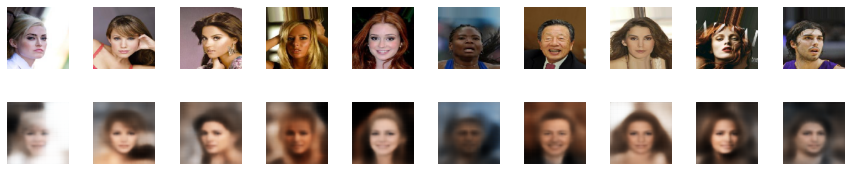

In [5]:
n_to_show = 10
data_flow_generic = image_loader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)
reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis("off")
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis("off")
    sub.imshow(img)

## 隐空间特征点的分布

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


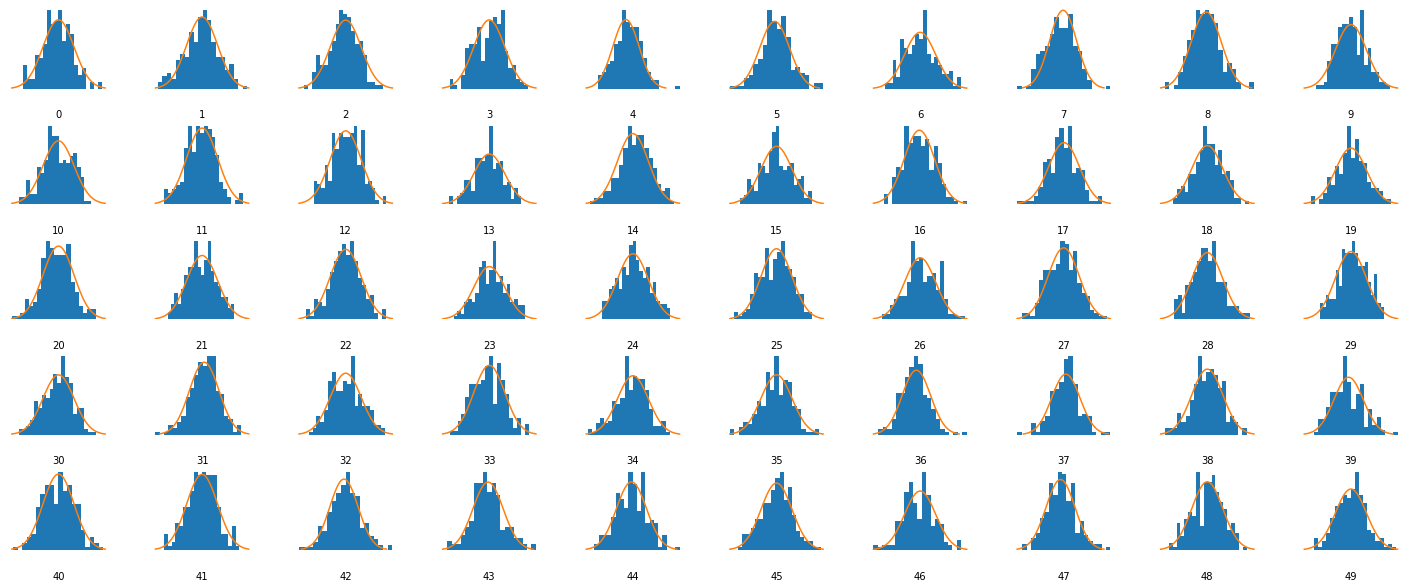

In [6]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps=20, verbose=1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

plt.show()

## 生成新面孔

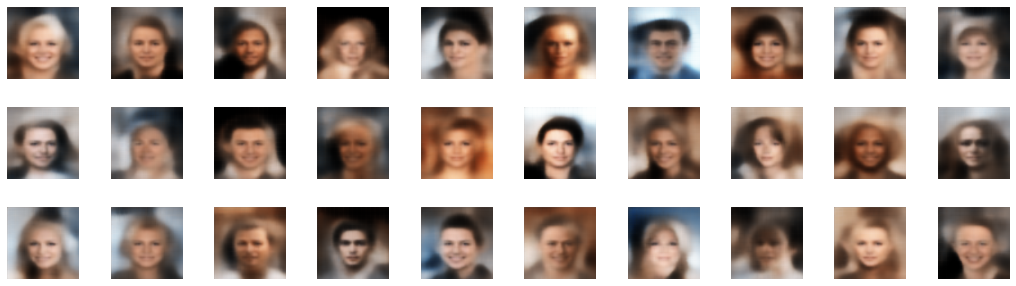

In [7]:
n_to_show = 30

znew = np.random.normal(size=(n_to_show, vae.z_dim))

reconst = vae.decoder.predict(znew)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :, :, :])
    ax.axis("off")
plt.show()

## 隐空间算数

In [8]:
def get_vector_from_label(label, batch_size):
    data_flow_label = image_loader.build(att, batch_size=batch_size, label=label)

    origin = np.zeros(shape=(vae.z_dim), dtype="float32")
    current_sum_POS = np.zeros(shape=(vae.z_dim), dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=(vae.z_dim), dtype="float32")

    current_sum_NEG = np.zeros(shape=(vae.z_dim), dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=(vae.z_dim), dtype="float32")

    current_vector = np.zeros(shape=(vae.z_dim), dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move : distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(im)

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)
        
        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)
        
        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(str(current_n_POS)
              + "\t: " + str(np.round(movement_POS, 3))
              + "\t: " + str(np.round(movement_NEG, 3))
              + "\t: " + str(np.round(new_dist, 3))
              + "\t: " + str(np.round(dist_change, 3)))
        
        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break
    
    return current_vector

In [9]:
def add_vector_to_images(feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))
    counter = 1
    for i in range(n_to_show):
        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors)+1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors)+1, counter)
            sub.axis("off")
            sub.imshow(img)

            counter += 1
    plt.show()

In [10]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move : distance : 𝛥 distance
260	: 1.033	: 1.001	: 1.536	: 1.536
516	: 0.676	: 0.624	: 1.296	: -0.24
769	: 0.358	: 0.358	: 1.212	: -0.084
1016	: 0.227	: 0.26	: 1.18	: -0.032
1256	: 0.194	: 0.198	: 1.134	: -0.047
1519	: 0.172	: 0.161	: 1.089	: -0.045
1758	: 0.129	: 0.138	: 1.055	: -0.034
2001	: 0.121	: 0.129	: 1.026	: -0.029
2278	: 0.102	: 0.103	: 1.008	: -0.018
2545	: 0.087	: 0.096	: 1.002	: -0.006
2808	: 0.082	: 0.083	: 0.989	: -0.013
3069	: 0.079	: 0.078	: 0.991	: 0.003
3321	: 0.065	: 0.072	: 0.989	: -0.002
3576	: 0.066	: 0.07	: 0.992	: 0.003
3834	: 0.061	: 0.059	: 0.974	: -0.018
4090	: 0.061	: 0.059	: 0.973	: -0.002
4337	: 0.049	: 0.053	: 0.966	: -0.007
4600	: 0.046	: 0.046	: 0.96	: -0.006
4851	: 0.046	: 0.046	: 0.964	: 0.004
5110	: 0.045	: 0.049	: 0.962	: -0.002
5359	: 0.039	: 0.042	: 0.961	: -0.001
5616	: 0.041	: 0.038	: 0.953	: -0.008
Found the Attractive vector
Found 202599 validated image filename

Smiling Vector


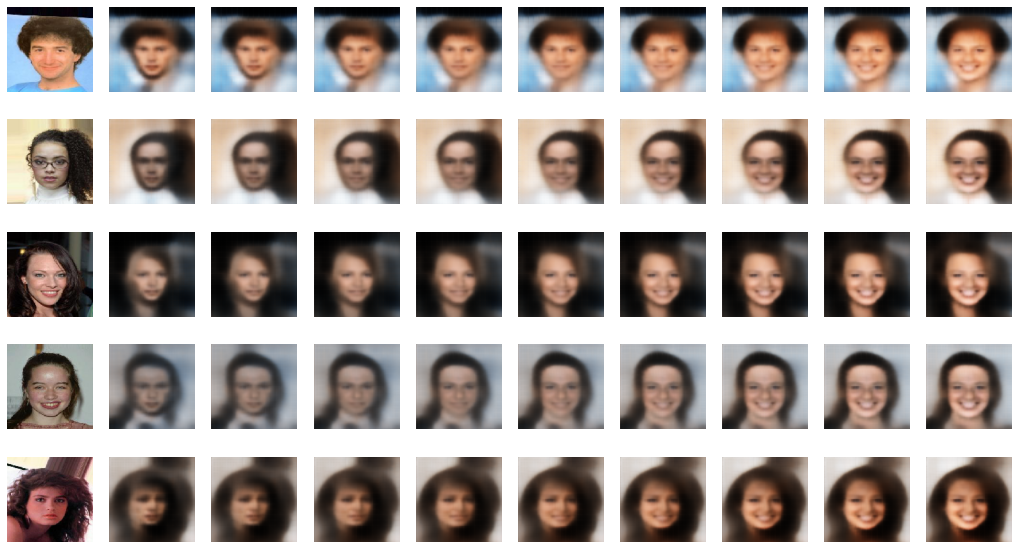

In [11]:
print('Smiling Vector')
add_vector_to_images(smiling_vec)

Blond Vector


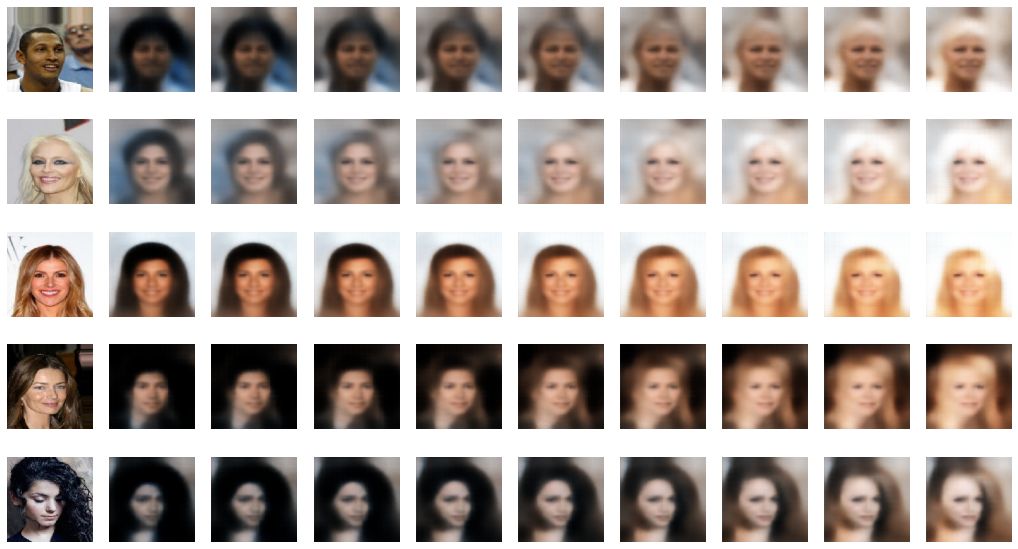

In [12]:
print('Blond Vector')
add_vector_to_images(blonde_vec)

Male Vector


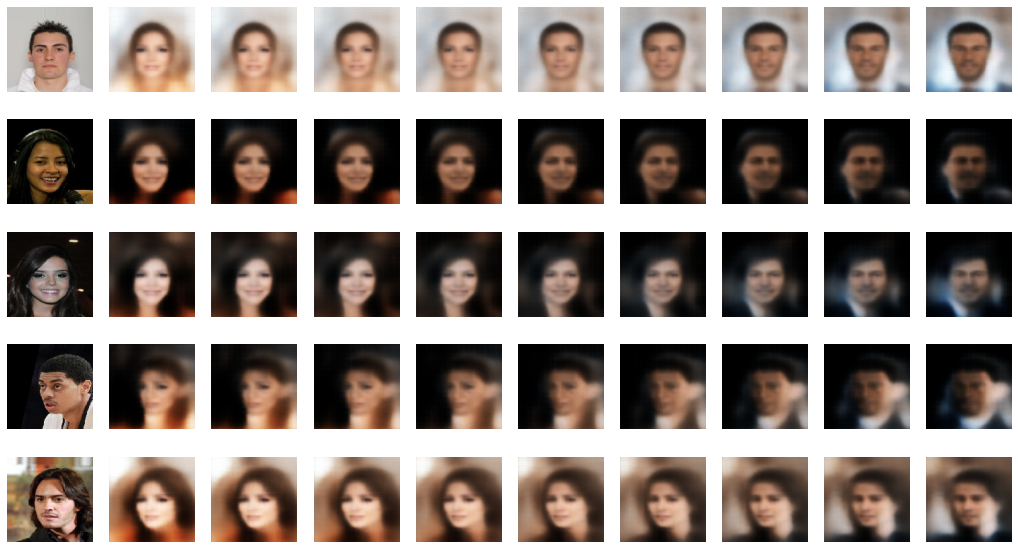

In [13]:
print('Male Vector')
add_vector_to_images(male_vec)

Eyeglasses Vector


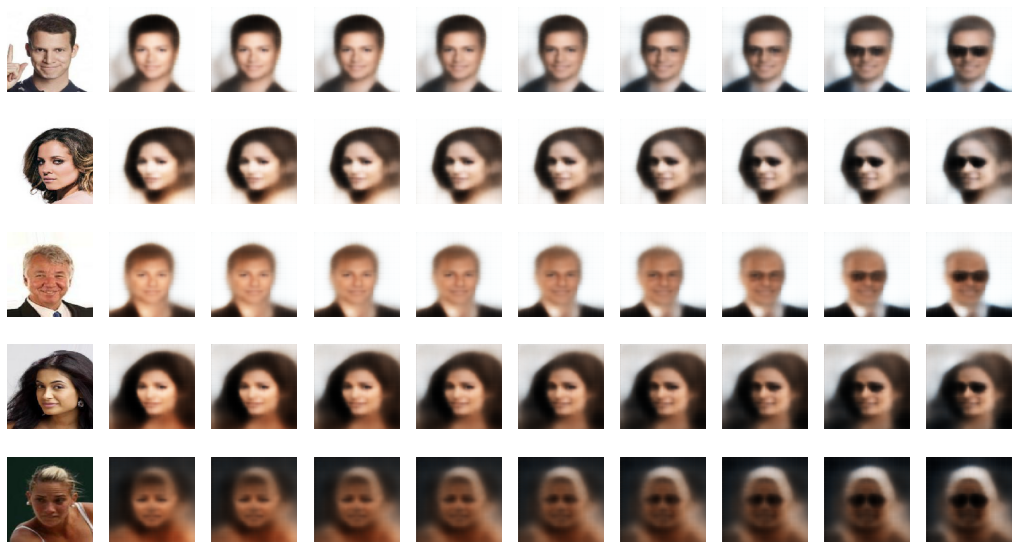

In [14]:
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

## 面部变形

In [15]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0, 1, 0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = image_loader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1
    for factor in factors:
        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    plt.show()

Found 2 validated image filenames.


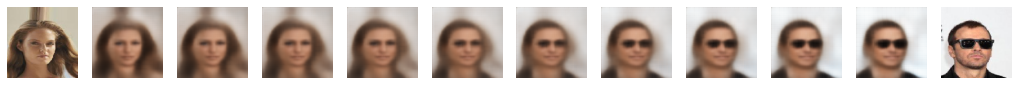

In [16]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


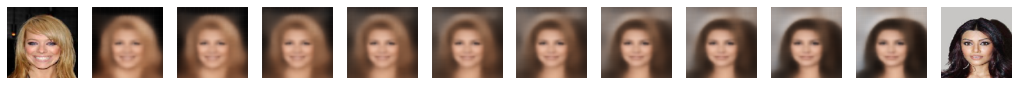

In [17]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


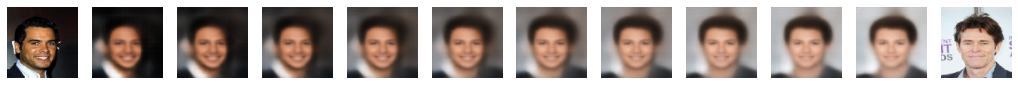

In [18]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)